<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/autoencoder/denoising_autoencoder_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import required libraries
import torch
import torchvision

import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print("CUDA is available!")
else:
  print("CUDA is not available!")

device = torch.device('cuda') if train_on_gpu else torch.device('cpu')

CUDA is available!


In [ ]:
# set up the general configeration
def set_all_seeds(seed):
  os.environ["PL_GLOBAL_SEED"] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

random_seed = 125
set_all_seeds(random_seed)

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()
# load dataset from torchvision.datasets module
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# number of subprocess to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()

    # encoder layers
    self.enConv1 = nn.Conv2d(1, 32, 3, padding=1)
    self.enConv2 = nn.Conv2d(32, 16, 3, padding=1)
    self.enConv3 = nn.Conv2d(16, 8, 3, padding=1)
    self.enPool = nn.MaxPool2d(2,2)

    # decoder layers
    self.deConv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)
    self.deConv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
    self.deConv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
    self.deConv4 = nn.Conv2d(32, 1, 3, padding=1)

  def forward(self, x):
    # encode
    x = F.relu(self.enConv1(x))
    x = self.enPool(x)
    x = F.relu(self.enConv2(x))
    x = self.enPool(x)
    x = F.relu(self.enConv3(x))
    x = self.enPool(x)

    # decode
    x = F.relu(self.deConv1(x))
    x = F.relu(self.deConv2(x))
    x = F.relu(self.deConv3(x))
    x = torch.sigmoid(self.deConv4(x))

    return x

model = VAE()
model.to(device)
print(model)

VAE(
  (enConv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enConv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enConv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (deConv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (deConv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (deConv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (deConv4): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [ ]:
import torch.optim as optim

# specify loss function
criterion = nn.MSELoss()

# specify optimizer
params = model.parameters()
optimizer = optim.Adam(params, lr=0.001)

In [ ]:
# num of epochs to train the model
num_epochs = 20

noise_factor = 0.5

# track training loss
train_losses = []

for epoch in range(num_epochs):
  # running train loss
  running_train_loss = 0.0

  for data in train_loader:
    # get the inputs; data is a list of [inputs, targets]
    inputs, _ = data

    # ----- create noisy data  -------
    # add random noise to the input images 
    noisy_inputs = inputs + noise_factor * torch.randn(*inputs.shape)
    # clip inputs in [0,1]
    noisy_inputs = np.clip(noisy_inputs, 0., 1.)

    # move tensor to the right device
    noisy_inputs = noisy_inputs.to(device)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass
    recon_inputs = model(noisy_inputs)
    # calculate the batch loss
    loss = criterion(recon_inputs, noisy_inputs)
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
    # update training loss
    running_train_loss += loss.item() * inputs.size(0)

  # calculate avg loss over an epoch
  running_train_loss = running_train_loss / len(train_loader)

  train_losses.append(running_train_loss)

  print("Epoch: {} \tTraining loss: {:.6f}".format(epoch+1, running_train_loss))

print("Finished training!")

Epoch: 1 	Training loss: 1.891713
Epoch: 2 	Training loss: 1.741918
Epoch: 3 	Training loss: 1.694545
Epoch: 4 	Training loss: 1.674604
Epoch: 5 	Training loss: 1.664243
Epoch: 6 	Training loss: 1.657269
Epoch: 7 	Training loss: 1.651986
Epoch: 8 	Training loss: 1.648236
Epoch: 9 	Training loss: 1.647115
Epoch: 10 	Training loss: 1.644651
Epoch: 11 	Training loss: 1.642020
Epoch: 12 	Training loss: 1.641008
Epoch: 13 	Training loss: 1.640010
Epoch: 14 	Training loss: 1.638539
Epoch: 15 	Training loss: 1.636589
Epoch: 16 	Training loss: 1.636650
Epoch: 17 	Training loss: 1.635387
Epoch: 18 	Training loss: 1.634393
Epoch: 19 	Training loss: 1.633806
Epoch: 20 	Training loss: 1.632442
Finished training!


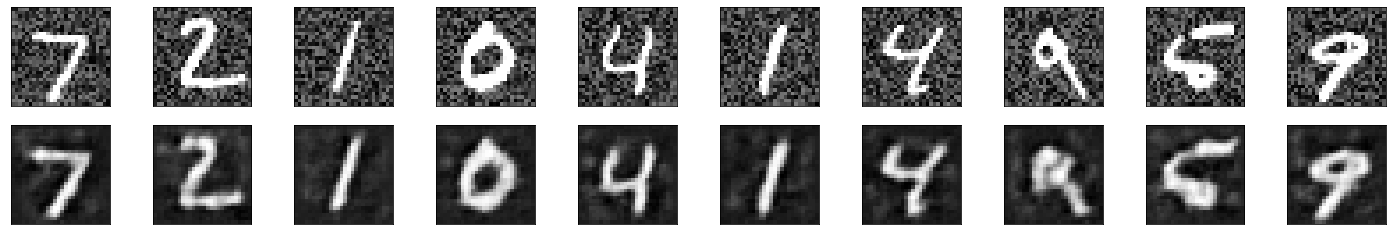

In [ ]:
# visualize one batch of noisy test images along with their reconstruction

# obtain one batch of test images
dataiter = iter(test_loader)
inputs, targets = dataiter.next()

# ----- create noisy data ---------
# add noise to the input images
noisy_inputs = inputs + noise_factor * torch.rand(*inputs.shape)
# clip inputs in [0,1]
noisy_inputs = np.clip(noisy_inputs, 0, 1)

# move noisy inputs to the right device
noisy_inputs = noisy_inputs.to(device)
# get sample outputs
recon_inputs = model(noisy_inputs)
# resize outputs into a batch of images
recon_inputs = recon_inputs.view(batch_size, 1, 28, 28)
# prepare images for display (use detach when it's an output that requires grad)
recon_inputs = recon_inputs.detach().numpy() if not train_on_gpu else recon_inputs.cpu().detach().numpy()

# display some inputs and their reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([noisy_inputs, recon_inputs], axes):
  for img, ax in zip(images, row):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)